# CIFAR-10 - Object Recognition in Images using CNN

## About Dataset

CIFAR-10  is an established computer-vision dataset used for object recognition. It is a subset of the 80
 million tiny images dataset and consists of 60,000 32x32 color images containing one of 10 object classes, 
 with 6000 images per class. It was collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton.



![cifar10](https://miro.medium.com/max/709/1*LyV7_xga4jUHdx4_jHk1PQ.png)

## Table of Contents



### Import Libaries

In [19]:
import os
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor,ToPILImage
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torchvision.utils import make_grid
import torch.nn as nn
import torch.nn.functional as F

### Exploring the Data

Extract from tar archive file

The dataset is extracted to the directory `input/cifar10`. It contains 2 folders `train` and `test`, containing the training set (50000 images) and test set (10000 images) respectively. Each of them contains 10 folders, one for each class of images. Let's verify this using `os.listdir`.

In [20]:
print(os.listdir('./input/cifar10'))
classes= os.listdir('./input/cifar10/train')
print(classes)

['labels.txt', 'test', 'train']
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Let's look inside a couple of folders, one from the training set and another from the test set. As an exercise, you can verify that that there are an equal number of images for each class, 5000 in the training set and 1000 in the test set.

In [21]:
cat_files= os.listdir('./input/cifar10/train/cat')
print('No of training example for cats:',len(cat_files))
print(cat_files[:5])


No of training example for cats: 5000
['10005_cat.png', '10011_cat.png', '10017_cat.png', '10021_cat.png', '1002_cat.png']


In [22]:
automobile_files= os.listdir('./input/cifar10/train/automobile')
print('No of training example for automobiles:',len(automobile_files))
print(automobile_files[:5])


No of training example for automobiles: 5000
['10000_automobile.png', '10022_automobile.png', '10035_automobile.png', '10039_automobile.png', '10049_automobile.png']


In [23]:
cat_files= os.listdir('./input/cifar10/test/cat')
print('No of test example for cats:',len(cat_files))
print(cat_files[:5])


No of test example for cats: 1000
['0_cat.png', '1014_cat.png', '1024_cat.png', '1030_cat.png', '1031_cat.png']


 We can use the `ImageFolder` class from `torchvision` to load the data as PyTorch tensors.

In [24]:
data_dir = './input/cifar10'
dataset = ImageFolder(data_dir+'/train', transform=ToTensor())


Let's look at a sample element from the training dataset. Each element is a tuple, containing a image tensor and a label. Since the data consists of 32x32 px color images with 3 channels (RGB), each image tensor has the shape `(3, 32, 32)`.

In [25]:
img, label= dataset[0]
print(img.shape,label)
img

torch.Size([3, 32, 32]) 0


tensor([[[0.8588, 0.8588, 0.8627,  ..., 0.8510, 0.8471, 0.8392],
         [0.8667, 0.8667, 0.8745,  ..., 0.8588, 0.8549, 0.8471],
         [0.8667, 0.8667, 0.8745,  ..., 0.8588, 0.8549, 0.8471],
         ...,
         [0.8980, 0.9020, 0.9098,  ..., 0.8980, 0.8902, 0.8863],
         [0.8471, 0.8549, 0.8706,  ..., 0.8980, 0.8902, 0.8824],
         [0.7608, 0.7490, 0.7725,  ..., 0.8980, 0.8902, 0.8824]],

        [[0.9333, 0.9333, 0.9373,  ..., 0.9176, 0.9137, 0.9059],
         [0.9412, 0.9412, 0.9490,  ..., 0.9294, 0.9216, 0.9137],
         [0.9412, 0.9412, 0.9490,  ..., 0.9255, 0.9216, 0.9137],
         ...,
         [0.9608, 0.9569, 0.9569,  ..., 0.9412, 0.9412, 0.9412],
         [0.9020, 0.9098, 0.9255,  ..., 0.9412, 0.9412, 0.9373],
         [0.8157, 0.8039, 0.8275,  ..., 0.9412, 0.9412, 0.9373]],

        [[0.9608, 0.9608, 0.9647,  ..., 0.9490, 0.9412, 0.9412],
         [0.9686, 0.9686, 0.9765,  ..., 0.9608, 0.9529, 0.9490],
         [0.9686, 0.9686, 0.9765,  ..., 0.9569, 0.9529, 0.

The list of classes is stored in the `.classes` property of the dataset. The numeric label for each element corresponds to index of the element's label in the list of classes.

In [26]:
dataset

Dataset ImageFolder
    Number of datapoints: 50000
    Root location: ./input/cifar10/train
    StandardTransform
Transform: ToTensor()

In [27]:
print(dataset.classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


We can view the image using `matplotlib`, but we need to change the tensor dimensions to `(32,32,3)` instead of `(3,32,32)`. Let's create a helper function to display an image and its label.

In [28]:
def show_image(img,label):
    print('Label: ', dataset.classes[label],"("+str(label)+")")
    plt.imshow(img.permute(1,2,0))

Label:  airplane (0)


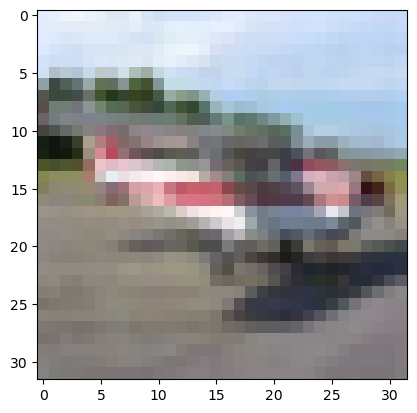

In [29]:
show_image(dataset[222][0],dataset[222][1])

Label:  airplane (0)


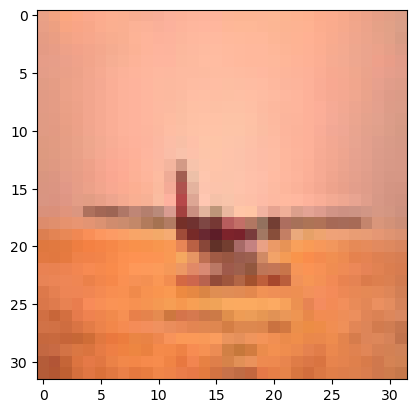

In [30]:
show_image(*dataset[1099])

Before continuing, let's save our work using the `jovian` python library. 


## Training and Validation Datasets

While building real world machine learning models, it is quite common to split the dataset into 3 parts:

1. **Training set** - used to train the model i.e. compute the loss and adjust the weights of the model using gradient descent.
2. **Validation set** - used to evaluate the model while training, adjust hyperparameters (learning rate etc.) and pick the best version of the model.
3. **Test set** - used to compare different models, or different types of modeling approaches, and report the final accuracy of the model.

Since there's no predefined validation set, we can set aside a small portion (5000 images) of the training set to be used as the validation set. We'll use the `random_split` helper method from PyTorch to do this. To ensure that we always create the same validation set, we'll also set a seed for the random number generator.

In [31]:
random_seed=42
torch.manual_seed(random_seed);

In [32]:
val_size = 5000
train_size = len(dataset) - val_size
train_ds, val_ds = random_split(dataset,[train_size, val_size],generator=torch.manual_seed(random_seed))
len(train_ds), len(val_ds)

(45000, 5000)

In [33]:
batch_size=128
train_dl = DataLoader(train_ds,batch_size,shuffle=True,num_workers=4,pin_memory=True )
val_dl = DataLoader(val_ds, batch_size, num_workers=4, pin_memory=True)

Tensor Image is a tensor with (C, H, W) shape, where C is a number of channels, H and W are image height and width. Batch of Tensor Images is a tensor of (B, C, H, W) shape, where B is a number of images in the batch.

In [34]:
train_dl # Data loader. Combines a dataset and a sampler, and provides an iterable over the given dataset.

In [35]:
def show_images_batch(d1):
    for images, labels in d1:
        fig, ax= plt.subplots(figsize=(16,8))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1,2,0))
        break # to stop loop otherwise 4500 images in batch size of 128 will print and is computationally expensive

### training data single batch images

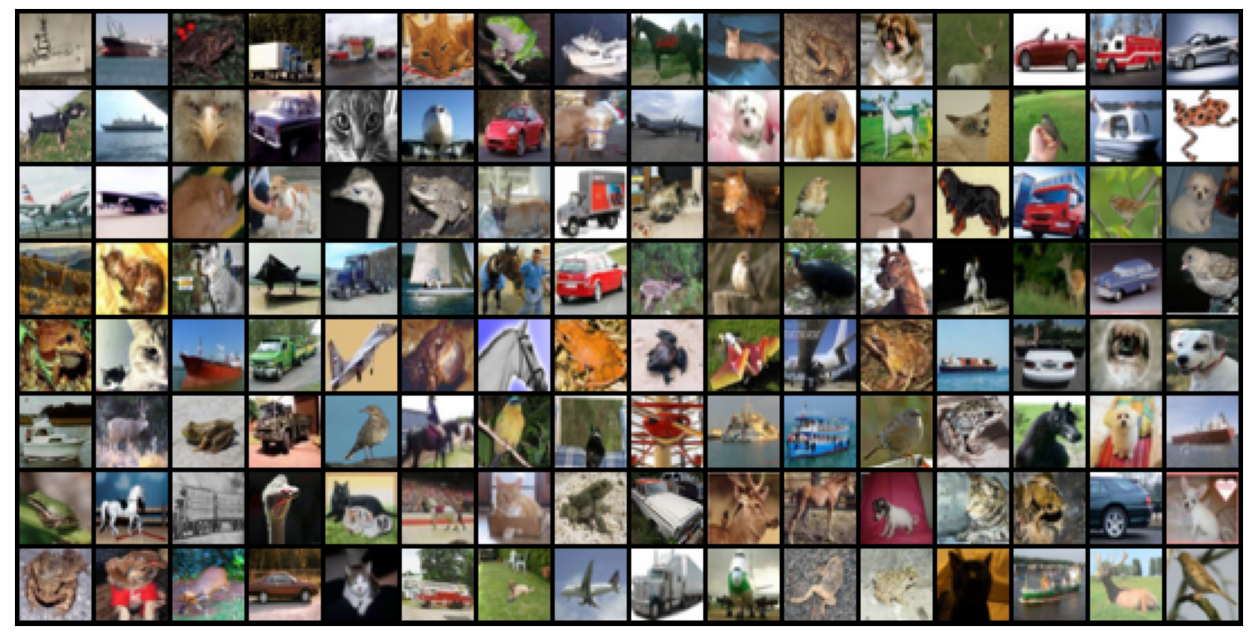

In [36]:
show_images_batch(train_dl) 

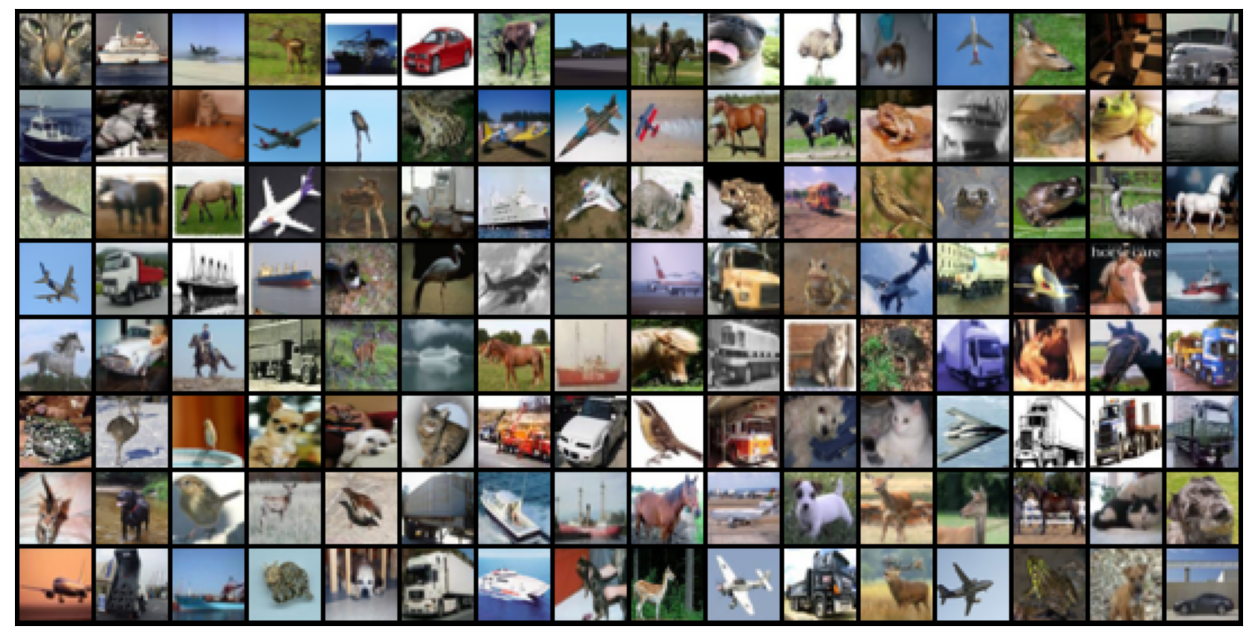

In [37]:
show_images_batch(val_dl)


## Convolutional Neural Network


### Defining the Model (Convolutional Neural Network)

The 2D convolution is a fairly simple operation at heart: you start with a kernel, which is simply a small matrix of weights. This kernel “slides” over the 2D input data, performing an elementwise multiplication with the part of the input it is currently on, and then summing up the results into a single output pixel.

<img src="https://miro.medium.com/max/1070/1*Zx-ZMLKab7VOCQTxdZ1OAw.gif" style="max-width:400px;">



Let us implement a convolution operation on a 1 channel image with a 3x3 kernel.

In [38]:
def apply_kernel(image, kernel):
    ri, ci = image.shape       # image dimensions
    rk, ck = kernel.shape      # kernel dimensions
    ro, co = ri-rk+1, ci-ck+1  # output dimensions, No padding and no striding
    output = torch.zeros([ro, co])
    for i in range(ro): 
        for j in range(co):
            output[i,j] = torch.sum(image[i:i+rk,j:j+ck] * kernel) 
    return output

In [39]:
sample_image = torch.tensor([
    [4, 4, 3, 1, 0], 
    [0, 0, 1, 4, 1], 
    [4, 1, 3, 3, 4], 
    [2, 0, 0, 3, 3], 
    [3, 0, 0, 0, 1]
], dtype=torch.float32)

sample_kernel = torch.tensor([
    [1, 1, 1], 
    [1, 1, 1], 
    [1, 1, 1]
], dtype=torch.float32) #blur filter

apply_kernel(sample_image, sample_kernel)

tensor([[20., 20., 20.],
        [11., 15., 22.],
        [13., 10., 17.]])

The `Conv2d` layer transforms a 3-channel image to a 16-channel *feature map*, and the `MaxPool2d` layer halves the height and width. The feature map gets smaller as we add more layers, until we are finally left with a small feature map, which can be flattened into a vector. We can then add some fully connected layers at the end to get vector of size 10 for each image.

<img src="https://i.imgur.com/KKtPOKE.png" style="max-width:540px">

Let's define the model by extending an `ImageClassificationBase` class which contains helper methods for training & validation.

In [40]:
def accuracy(outputs,labels):
    _,preds= torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds==labels).item()/len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self,batch):
        images,labels= batch
        out= self(images)  #Generate predictions
        loss= F.cross_entropy(out,labels) #calculate loss
        return loss
    
    def validation_step(self,batch):
        images, labels = batch
        out = self(images)  # Generate predictions
        loss= F.cross_entropy(out,labels) # calculate loss
        acc= accuracy(out,labels)
        return {'val_loss':loss.detach(), 'val_acc':acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss= torch.stack(batch_losses).mean() # Stacking losses to combine losses and calculate average
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean() # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
        
    def epoch_end(self,epoch,result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

`detach()` detaches the output from the computationnal graph. So no gradient will be backproped along this variable.

`torch.no_grad` says that no operation should build the graph.


The difference is that one refers to only a given variable on which it’s called. The other affects all operations taking place within the with statement.tensor.detach() creates a tensor that shares storage with tensor that does not require grad. It detaches the output from the computational graph. So no gradient will be backpropagated along this variable.

The wrapper with torch.no_grad() temporarily set all the requires_grad flag to false. torch.no_grad says that no operation should build the graph.

The difference is that one refers to only a given variable on which it is called. The other affects all operations taking place within the with statement. Also, torch.no_grad will use less memory because it knows from the beginning that no gradients are needed so it doesn’t need to keep intermediary results.

We'll use `nn.Sequential` to chain the layers and activations functions into a single network architecture.

In [41]:
class Cifar10CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))
        
    def forward(self, xb):
        return self.network(xb)

In [42]:
model= Cifar10CnnModel()
model

Cifar10CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_feat

In [43]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:',out.shape)
    print('out[0]',out[0])
    break

images.shape: torch.Size([128, 3, 32, 32])
out.shape: torch.Size([128, 10])
out[0] tensor([-0.0060,  0.0394,  0.0185,  0.0062, -0.0312,  0.0362,  0.0084, -0.0271,
         0.0122, -0.0045], grad_fn=<SelectBackward0>)


In [44]:
out.shape

torch.Size([128, 10])

In [45]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

Based on where you run this notebook, your default device could be a CPU (`torch.device('cpu')`) or a GPU (`torch.device('cuda')`)

In [46]:
device = get_default_device()
device

device(type='cpu')

We can now wrap our training and validation data loaders using `DeviceDataLoader` for automatically transferring batches of data to the GPU (if available), and use `to_device` to move our model to the GPU (if available).

In [47]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device) # load data to device (GPU if available)
to_device(model, device) # move model to GPU if available

Cifar10CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_feat

<a id="6"></a>
## Training the Model

In this mode, the result of every computation will have requires_grad=False, even when the inputs have requires_grad=True.

In [48]:

@torch.no_grad() 
def evaluate(model, val_loader):
    model.eval() # Setting model to evaluation mode, the model can adjust its behavior regarding some operations, like Dropout.
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)
  
def fit(epochs, lr, model, train_loader, val_loader, opt_func= torch.optim.SGD):
    history=[]
    optimizer= opt_func(model.parameters(),lr) # model paramters w.r.t calculate derivative of loss
    for epoch in range(epochs):
        # Training phase
        model.train() # Setting model to training mode
        train_losses=[]
        for batch in train_loader:
            loss= model.training_step(batch)
            train_losses.append(loss)
            loss.backward() #compute  gradients
            optimizer.step()
            optimizer.zero_grad() # zero the gradients
        #Validation phase
        result= evaluate(model,val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history
            

In [49]:
model

Cifar10CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_feat

The initial accuracy is around 10% in one epoch, which is expected model is not trained enough.

In [50]:
evaluate(model,val_dl)

{'val_loss': 2.3026108741760254, 'val_acc': 0.09492187201976776}

In [51]:
num_epochs = 15
opt_func = torch.optim.Adam
lr = 0.001

If you are interested, you can use fit to train the model, but this can take more than one and a half hours. So to save time, we provide the trained model.

In [52]:
# history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)
history = torch.load('cnn-cifar10-model.pth')

Plot valdation set accuracies to study how the model improves over time.

In [53]:
def plot_accuracies(history):
    accuracies=[x['val_acc'] for x in history]
    plt.plot(accuracies,'-x')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs No of epochs')

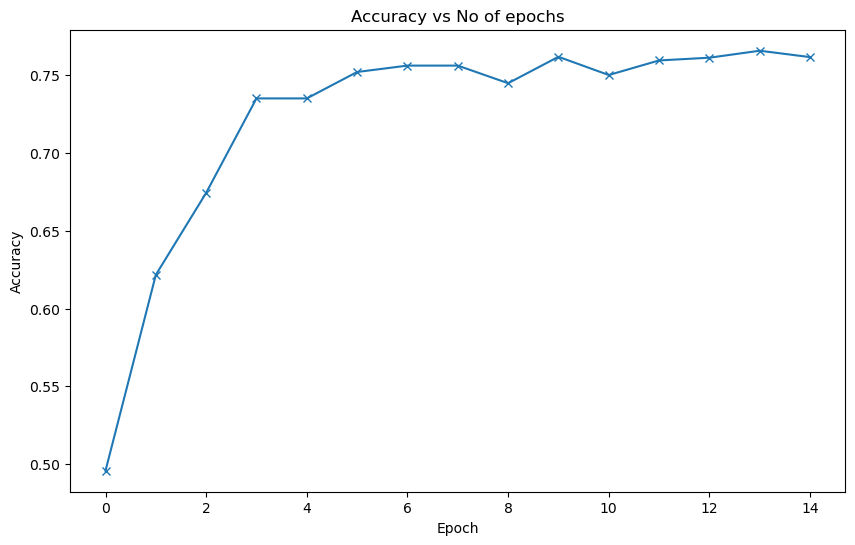

In [54]:
plt.figure(figsize=(10,6))
plot_accuracies(history)

Our model reaches an accuracy of around 75%, and by looking at the graph, it seems unlikely that the model will achieve an accuracy higher than 80% even after training for a long time. This suggests that we might need to use a more powerful model to capture the relationship between the images and the labels more accurately.

In [55]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

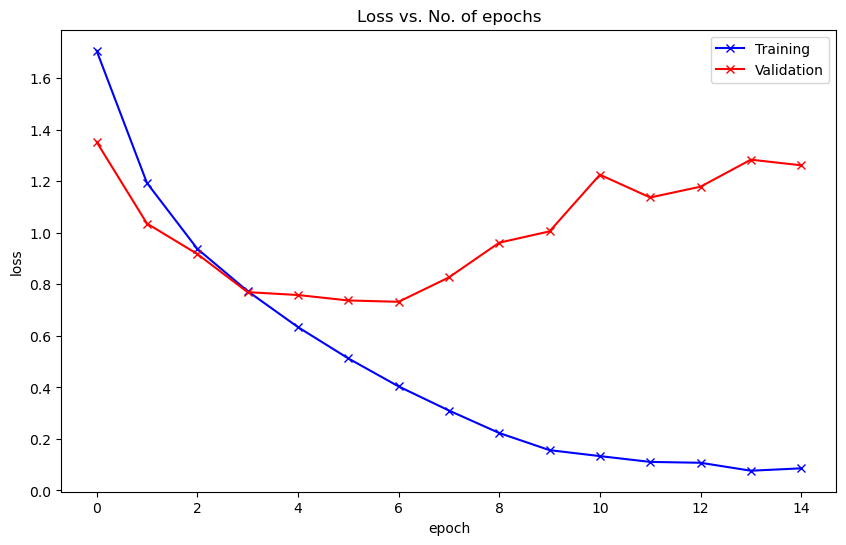

In [56]:
plt.figure(figsize=(10,6))
plot_losses(history)

Initialy, both the training and validation losses seem to decrease over time. However, if we train the model for long enough,training loss continues to decrease, while the validation loss stops decreasing, and even starts to increase after a certain point(overfitting).


## Testing with individual images

In [57]:
test_dataset = ImageFolder(data_dir+'/test', transform=ToTensor())
test_dataset

Dataset ImageFolder
    Number of datapoints: 10000
    Root location: ./input/cifar10/test
    StandardTransform
Transform: ToTensor()

In [58]:
def predict_image(img, model):
    xb= to_device(img.unsqueeze(0),device) # unsqueeze turns an n-dimensionsal tensor into an n+1-dimensional one. But since it is ambiguous which axis the new dimension lies across, this needs to be specified.
    # Get predictions from model
    yb = model(xb)
    # Pick index/label with highest probability
    _, preds= torch.max(yb, dim=1)
    return dataset.classes[preds[0].item()]

Label: airplane , Predicted: automobile


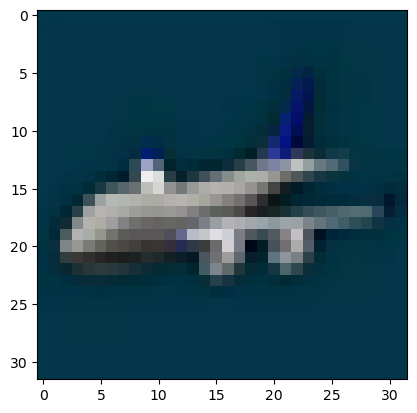

In [59]:
img,label= test_dataset[8]
plt.imshow(img.permute(1,2,0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: automobile , Predicted: automobile


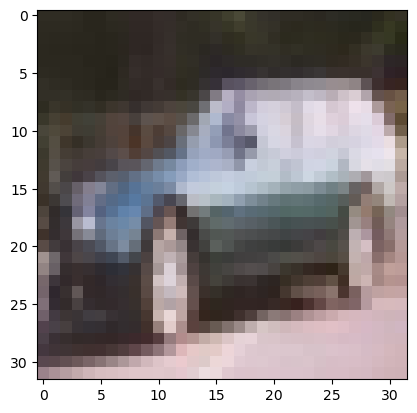

In [60]:
img,label= test_dataset[1220]
plt.imshow(img.permute(1,2,0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: airplane , Predicted: automobile


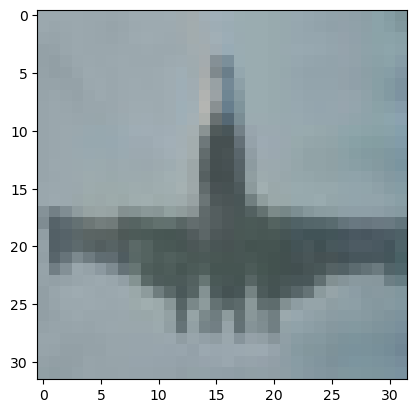

In [61]:
img,label= test_dataset[345]
plt.imshow(img.permute(1,2,0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: frog , Predicted: automobile


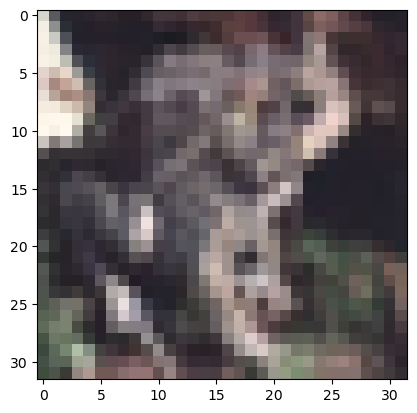

In [62]:
img,label= test_dataset[6153]
plt.imshow(img.permute(1,2,0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: airplane , Predicted: automobile


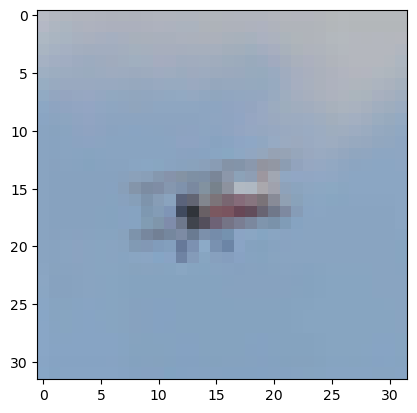

In [63]:
img,label= test_dataset[456]
plt.imshow(img.permute(1,2,0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: airplane , Predicted: automobile


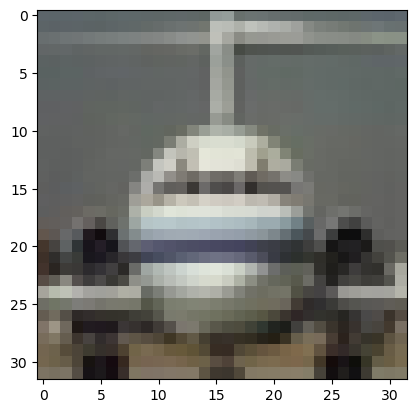

In [64]:
img,label= test_dataset[10]
plt.imshow(img.permute(1,2,0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

`Identifying where our model performs poorly can help us improve the model, by collecting more training data, 
increasing/decreasing the complexity of the model, and changing the hypeparameters.`

Label: automobile , Predicted: automobile


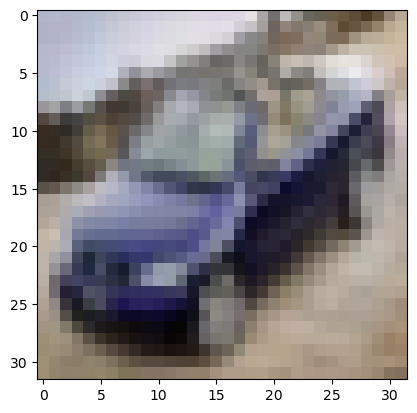

In [65]:
img,label= test_dataset[1432]
plt.imshow(img.permute(1,2,0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

In [66]:
test_loader=DeviceDataLoader(DataLoader(test_dataset,batch_size),device)
test_result = evaluate(model, test_loader)
test_result

{'val_loss': 2.3029396533966064, 'val_acc': 0.09889240562915802}

## Acknowledgments

Thanks to datajameson for creating the open-source course [Cifar-10 Object Recognition(CNN) Explained](https://www.kaggle.com/code/datajameson/cifar-10-object-recognition-cnn-explained). It inspires the majority of the content in this chapter.